In [1]:
import numpy as np
import cv2 
import seaborn as sns
from IPython.display import Image
from keras.models import load_model
from face_classification.utils.datasets import get_labels
from face_classification.utils.inference import detect_faces
from face_classification.utils.inference import draw_text
from face_classification.utils.inference import draw_bounding_box
from face_classification.utils.inference import apply_offsets
from face_classification.utils.inference import load_detection_model
from face_classification.utils.inference import load_image
from face_classification.utils.preprocessor import preprocess_input

Using TensorFlow backend.


In [2]:
# hyper-parameters for bounding boxes shape
emotion_offsets = (20, 40)
emotion_offsets = (0, 0)

# aesthetic hyperparameters
color = (255, 0, 0)
font = cv2.FONT_HERSHEY_SIMPLEX

In [3]:
# loading models
model_path = '/home/ktran/face_classification/trained_models/'

detection_model_path = model_path + 'detection_models/haarcascade_frontalface_default.xml'
face_detection = load_detection_model(detection_model_path)

emotion_model_path = model_path + 'emotion_models/fer2013_mini_XCEPTION.102-0.66.hdf5'
emotion_classifier = load_model(emotion_model_path, compile=False)
emotion_target_size = emotion_classifier.input_shape[1:3]
emotion_labels = get_labels('fer2013')

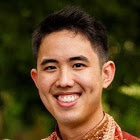

In [4]:
# loading and processing image
image_path = 'me.jpg'

rgb_image = load_image(image_path, grayscale=False)
gray_image = load_image(image_path, grayscale=True)
gray_image = np.squeeze(gray_image)
gray_image = gray_image.astype('uint8')

Image(filename=image_path)

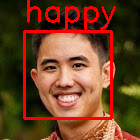

In [5]:
# Detect all the faces, and then process each face
faces = detect_faces(face_detection, gray_image)
for face_coordinates in faces:
    x1, x2, y1, y2 = apply_offsets(face_coordinates, emotion_offsets)
    rgb_face = rgb_image[y1:y2, x1:x2]
    gray_face = gray_image[y1:y2, x1:x2]

    try:
        gray_face = cv2.resize(gray_face, (emotion_target_size))
    except:
        continue

    rgb_face = preprocess_input(rgb_face, False)
    rgb_face = np.expand_dims(rgb_face, 0)

    gray_face = preprocess_input(gray_face, True)
    gray_face = np.expand_dims(gray_face, 0)
    gray_face = np.expand_dims(gray_face, -1) 
    emotion_label_arg = np.argmax(emotion_classifier.predict(gray_face))
    emotion_text = emotion_labels[emotion_label_arg]

    draw_bounding_box(face_coordinates, rgb_image, color)
    draw_text(face_coordinates, rgb_image, emotion_text, color, 0, -10, 1, 2)

# Save and display the labeled image
output_path = 'test.png'
bgr_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)
cv2.imwrite(output_path, bgr_image)
Image(filename=output_path)

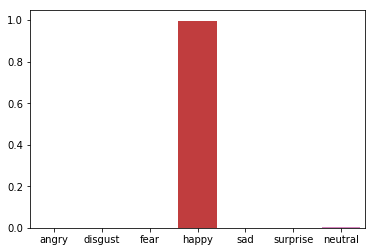

In [6]:
# Show the emotional propensities of one of the faces
face_index = 0
emotional_propensities = emotion_classifier.predict(gray_face)
ax = sns.barplot(x=emotion_labels.values(), y=emotional_propensities[face_index])